In [35]:
import math
import os
import pandas as pd
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
import nltk
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, GRU, Dense, Embedding
from keras.utils import  pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from sklearn.model_selection import train_test_split

### Loading the Dataset
Here we load the data from the `dataset.csv` file (generated in the other script)

In [2]:
def load_data():
    return pd.read_csv('data/fraction/dataset-200-1.csv')

In [3]:
def load_vocabulary():
    vocabulary = list()
    with open('data/vocab.30K.txt', encoding='utf-8') as f:
        for line in f:
            vocabulary.append(line.strip())
    return vocabulary

### Data pre-processing
Transform to lower, remove the new line and the punctuation

In [4]:
def lower_data(data):
    return data.str.lower() 
    
def clean_data(data):
    return data.str.replace(',', ' ,')                \
                .str.replace('.',' . ', regex=False)  \
                .str.replace('?',' ?', regex=False)   \
                .str.replace(r"[^a-zA-Z0-9?'.,]+",' ',regex=True)

def get_data():
    data = load_data()
    for column in data.columns:    
        data[column] = lower_data(data[column])
        data[column] = clean_data(data[column])
    return shuffle(data)

### Data analysis
Mean sentence length and standard deviation of sentence length

In [5]:
def print_data_analysis(data):
    print('Central tendency, dispersion and shape of questions’s distribution')
    print(data['question'].str.len().describe().apply(lambda x: format(x, 'f')))
    print('-'*100)
    print('Central tendency, dispersion and shape of answers’s distribution')
    print(data['answer'].str.len().describe().apply(lambda x: format(x, 'f')))

In [6]:
#print_data_analysis(dataset)

In [7]:
def remove_outliers(data):
    return data[(data['question'].str.len() < 100) & (data['answer'].str.len() < 200)]

def padd_data(data):
    data = data.assign(question = '<start> ' + data.question  + ' <end>')
    data = data.assign(answer = '<start> ' + data.answer  + ' <end>')
    return data

In [8]:
import unicodedata
import re

# Convert the unicode sequence to ascii
def unicode_to_ascii(s):

    # Normalize the unicode string and remove the non-spacking mark
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Preprocess the sequence
def preprocess_sentence(w):

    # Clean the sequence
    w = unicode_to_ascii(w.lower().strip())

    # Create a space between word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # Add a start and stop token to detect the start and end of the sequence
    w = '<start> ' + w + ' <end>'
    return w

### Creating the dataset
Removing the outliers and adding <start> and <end> for each question, awnser pair

In [9]:
def create_dataset(num_examples):
    dataset = remove_outliers(get_data())
    dataset = padd_data(dataset)
    return dataset['question'].tolist(), dataset['answer'].tolist()

### Tokenizing 
Tokenize the data, padd the sequence and create the vocabulary

In [10]:
def load_tokenize(vocabulary):
    tokenizer = Tokenizer(filters='!"#$%&()*+-:;=@[\\]^_{|}~\t')
  
    # Convert sequences into internal vocab
    tokenizer.fit_on_texts(vocabulary)

    return tokenizer

In [11]:
def tokenize(text, tokenizer):

    # Convert internal vocab to numbers
    tensor = tokenizer.texts_to_sequences(text)

    # Pad the tensors to assign equal length to all the sequences
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', truncating='post',maxlen=None)

    return tensor

### Load the clean and formated data 

In [12]:
def load_dataset(num_examples=None):
 
    questions, answers = create_dataset(num_examples=None)
    vocabulary = load_vocabulary()
    
    #Create the tokenizer for inputs and outputs
    tokenizer = load_tokenize(vocabulary)
    
    questions_tensor = tokenize(questions, tokenizer)
    answers_tensor = tokenize(answers, tokenizer)

    return questions_tensor, answers_tensor, tokenizer

In [13]:
questions_tensor, answers_tensor, tokenizer = load_dataset()

### Split in train and test
Split 80% of the data to train and 20% for testing

In [14]:
max_length_input, max_length_target = questions_tensor.shape[1], answers_tensor.shape[1]
input_train, input_test, target_train, target_test = train_test_split(questions_tensor, answers_tensor, test_size=0.2)

print("Test count:", len(input_train))
print("Train count:", len(input_test))


Test count: 82
Train count: 21


In [15]:
def convert(text, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, text.index_word[t]))
      
print("Input question; index to word mapping")
convert(tokenizer, input_train[0])
print()
print("Target awnser; index to word mapping")
convert(tokenizer, target_train[0])

Input question; index to word mapping
1132 ----> <start>
206 ----> men
112 ----> of
1135 ----> ,
1539 ----> who's
1136 ----> your
23778 ----> mancrush
172 ----> ?
1133 ----> <end>

Target awnser; index to word mapping
1132 ----> <start>
173 ----> that
503 ----> dude
4 ----> in
68 ----> the
2593 ----> mirror
111 ----> i
1218 ----> keep
1452 ----> seeing
1134 ----> .
1332 ----> seems
28 ----> to
174 ----> have
14 ----> a
1184 ----> lot
360 ----> going
88 ----> for
354 ----> him
1134 ----> .
1134 ----> .
1134 ----> .
1133 ----> <end>


### Setting the hyperparameter

In [16]:
BUFFER_SIZE = len(input_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_input_size = len(tokenizer.word_index) + 1
vocab_target_size = len(tokenizer.word_index) + 1

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2023-07-24 16:38:35.498868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 16:38:35.544404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 16:38:35.544588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 16:38:35.545121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [18]:
iter(dataset)

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 23]), TensorShape([64, 45]))

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units

        # Embed the vocab to a dense embedding 
        self.embedding = Embedding(vocab_size, embedding_dim)

        # GRU Layer
        # glorot_uniform: Initializer for the recurrent_kernel weights matrix, 
        # used for the linear transformation of the recurrent state
        self.gru = GRU(self.encoder_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # Encoder network comprises an Embedding layer followed by a GRU layer
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    # To initialize the hidden state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

In [21]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (64, 23, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


2023-07-24 16:38:36.441756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


In [22]:
# Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # values shape == (batch_size, max_len, hidden size)

        # we are doing this to broadcast addition along the time axis to calculate the score
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 23, 1)


In [24]:
# Decoder class
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # x shape == (batch_size, 1)
        # hidden shape == (batch_size, max_length)
        # enc_output shape == (batch_size, max_length, hidden_size)

        # context_vector shape == (batch_size, hidden_size)
        # attention_weights shape == (batch_size, max_length, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_target_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 28533)


In [26]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

    # Take care of the padding. Not all sequences are of equal length.
    # If there's a '0' in the sequence, the loss is being nullified
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    # tf.GradientTape() -- record operations for automatic differentiation
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # dec_hidden is used by attention, hence is the same enc_hidden
        dec_hidden = enc_hidden

        # <start> token is the initial decoder input
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):

            # Pass enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            # Compute the loss
            loss += loss_function(targ[:, t], predictions)

            # Use teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    # As this function is called per batch, compute the batch_loss
    batch_loss = (loss / int(targ.shape[1]))

    # Get the model's variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute the gradients
    gradients = tape.gradient(loss, variables)

    # Update the variables of the model/network
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [29]:
import time
EPOCHS = 30

# Training loop
with tf.device('/cpu:0'):
    for epoch in range(EPOCHS):
        start = time.time()

        # Initialize the hidden state
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        # Loop through the dataset
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

            # Call the train method
            batch_loss = train_step(inp, targ, enc_hidden)

            # Compute the loss (per batch)
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

        # Save (checkpoint) the model every 2 epochs
        #if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

        # Output the loss observed until that epoch
        print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))

        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2023-07-24 16:39:22.284184: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.00MiB (rounded to 5242880)requested by op transpose_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-07-24 16:39:22.284266: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-07-24 16:39:22.284304: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 152, Chunks in use: 152. 38.0KiB allocated for chunks. 38.0KiB in use in bin. 16.2KiB client-requested in use in bin.
2023-07-24 16:39:22.284332: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 34, Chunks in use: 31. 17.5KiB allocated for chunks. 16.0KiB in use in bin. 15.5KiB client-requested in use in bin.
2023-07-24 16:39:22.284356

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[1024,1280] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node transpose_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[decoder/gru_1/PartitionedCall_13]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_81496]

In [ ]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(sentence):

    # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
    attention_plot = np.zeros((max_length_target, max_length_input))

    # Preprocess the sentence given
    sentence = preprocess_sentence(sentence)

    # Fetch the indices concerning the words in the sentence and pad the sequence
    inputs = [tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_input,
                                                         padding='post')
    # Convert the inputs to tensors
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    # Loop until the max_length is reached for the target lang (ENGLISH)
    for t in range(max_length_target):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        
        # Store the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # Get the prediction with the maximum attention
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        # Append the token to the result
        result += tokenizer.index_word[predicted_id] + ' '

        # If <end> token is reached, return the result, input, and attention plot
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # The predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [88]:
# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
# Function for plotting the loss values
def plot_loss(loss_values):
    plt.plot(loss_values)

    plt.xlabel('Epocs',fontsize=11)
    plt.ylabel('Loss',fontsize=11)
    plt.tight_layout()
    plt.margins(x=0.01, y=0.5)

    plt.show()

In [ ]:
def response(sentence, print_out=False):
    result, sentence, attention_plot = evaluate(sentence)
    return result, attention_plot

In [32]:
def bleu_score(expected, predicted):
    expected = [expected.split()]
    predicted = predicted.split()
    return sentence_bleu(expected, predicted, smoothing_function=SmoothingFunction().method4)

In [ ]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
sentence = u'Hello.'
result, attention_plot = response(sentence)

#Printing the result
print('Input: %s' % (sentence))
print('Predicted awnser: {}'.format(result))
    
#Ploting the attention
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [34]:
#Printing BLEU score
sentence = 'that is what i am talking about and no one get it'
predicted = 'that is what i am talking about and no one understands'
bscore = bleu_score(sentence, predicted)
print(bscore)

0.8155395405382073


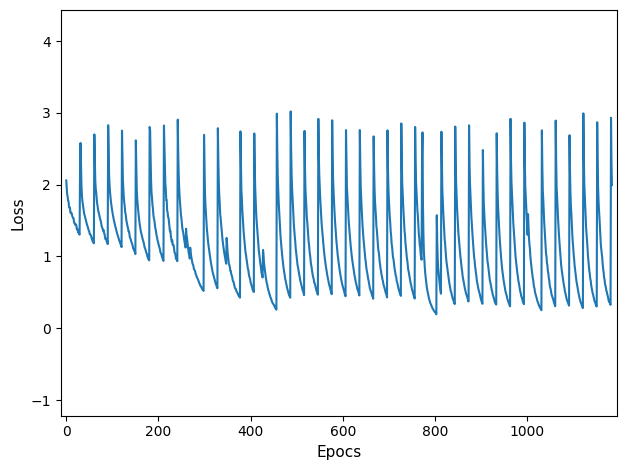

In [89]:
#Ploting loss
loss_file = open("loss.txt", "r")
data = loss_file.read()
data_loss_list = data.split("\n")
loss_file.close()

data_loss_list = [i for i in data_loss_list if i]
data_loss = [float(i) for i in data_loss_list]

plot_loss(data_loss)